Hello everone!

Today I'm propsing a binary classifier that can predict if a person would be able to pay off his loan to the bank or not.

In [277]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [278]:
df = pd.read_csv('~/Downloads/loan.csv')

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's quickly explore how this data looks like.

In [279]:
df.dtypes

id                               int64
member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs              

As you can see there are a lot of features, 74 to be exact.

# Remove missing data

I'm going to drop columns that have more than 50% of missing values

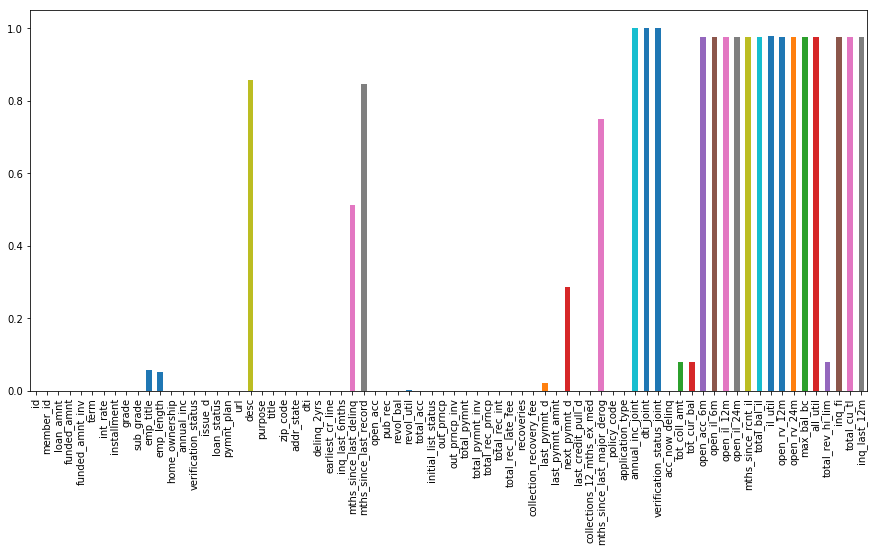

In [280]:
(df.isnull().sum()/len(df)).plot(kind="bar",figsize=(15,7))

In [281]:
missing_50 = df.columns[df.isnull().sum()/len(df) > 0.5]
missing_50

Index(['desc', 'mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi',
       'total_cu_tl', 'inq_last_12m'],
      dtype='object')

In [283]:
df.drop(missing_50 , axis=1, inplace=True)

In [284]:
df.shape

(887379, 53)

I now have 53 features.

## Modifying Target Column

The target column I am interested in is `loan_status`. Let's explore how this column is composed of.

In [19]:
df.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Here is a quick summary for how our target column looks like, however we want to make this a binary classification problem, so we are only interested in two types: risky and safe customers.

Meaning of loan status is described below:

|Loan Status|Meaning|
|---:|:---|
|Current|Loan is up to date on all outstanding payments.|
|Fully Paid|Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.|
|Charged Off|Loan for which there is no longer a reasonable expectation of further payments. Generally, Charge Off occurs no later than 30 days after the Default status is reached. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance.|
|Late (31-120 days)|Loan has not been current for 31 to 120 days.|
|Issued|New loan that has passed all LendingClub reviews, received full funding, and has been issued.|
|In Grace Period|Loan is past due but within the 15-day grace period.|
|Late (16-30 days)|Loan has not been current for 16 to 30 days.|
|Default|Loan has not been current for 121 days or more.|

First of all, `Current` and `Issued` loans are still in progress, so they cannot be used for training. Let's drop them.

In [285]:
df = df[~df.loan_status.isin(['Current', 'Issued','Late (31-120 days)','Late (16-30 days)','In Grace Period'])]

There are many classes in `loan_status` feature. However, I want to divide it to 2 classses: bad and safe.


<table>
  <tr>
    <td>Loan Status</td>
    <td>Class</td>
    <td>Code</td>
  </tr>
  <tr>
    <td>Fully Paid</td>
    <td rowspan="2">Safe</td>
    <td rowspan="2">1</td>
  </tr>
  <tr>
    <td>Does not meet the credit policy. Status:Fully Paid</td>
  </tr>
  <tr>
    <td>Charged Off</td>
    <td rowspan="3">Bad</td>
    <td rowspan="3">0</td>
  </tr>
  <tr>
    <td>Does not meet the credit policy. Status:Charged Off</td>
  </tr>
  <tr>
    <td>Default</td>
  </tr>
</table>

In [287]:
bad_index = ['Charged Off', 'Does not meet the credit policy. Status:Charged Off', 'Default']

safe_index = ['Fully Paid','Does not meet the credit policy. Status:Fully Paid']

Now i will map the safe customers as 1, and the risky ones as zero.

In [1]:
map_labels = dict(zip(bad_index+safe_index,[0]*3 + [1]*3))

df.loan_status = df.loan_status.map(map_labels)

NameError: name 'bad_index' is not defined

Lets continue by examining the other features

Drop columns that are unimportant. 

We only want to keep information that is available at loan *application* stage because otherwise they will leak information.

In [289]:
drop_list = [
     #Unique identifiers for Customers (Unimportant)
    'id','member_id', 
    
     #Remaining outstanding principal (Not available at the application stage)
    'out_prncp','out_prncp_inv', 
    
    #Total amount committed to the loan (Not available at the application stage)
    "funded_amnt","funded_amnt_inv", 
    
    # Payments received to date (Not available at the application stage)
    "total_pymnt",'total_pymnt_inv', 
    
    #Principal and fees received to date (Not available at the application stage)
    'total_rec_prncp', 'total_rec_int','total_rec_late_fee', 
    
    #post charge off gross recovery (Not available at the application stage)
    "recoveries","collection_recovery_fee",
    
    #Loan Payment information (Not available at the application stage)
    "issue_d","last_pymnt_d","last_pymnt_amnt","next_pymnt_d",
]
df.drop(drop_list,axis=1, inplace=True)

In [290]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,...,9.0,f,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,...,4.0,f,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,...,10.0,f,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,...,37.0,f,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
5,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,...,12.0,f,Sep-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


In [291]:
df.shape

(256939, 36)

#  Multicollinearity

Let's explore how the remaining features and see if any of the features are highly correlated with each other

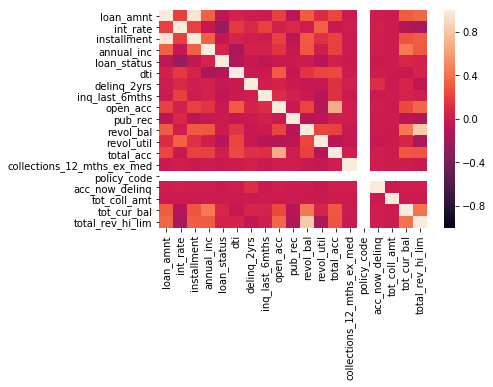

In [25]:
sns.heatmap(df.corr(),
            vmin=-1,
            vmax=1,
            )

Here I examined the correlation between all the variables and dropped the columns that exhibit multilinearity.

In [26]:
correlation = df.corr()
correlated_columns = (correlation > 0.6) 

for column in correlation.columns:
    var = correlation[column][correlated_columns[column]].index
    if len(var) > 1:
        print(var.values)

['loan_amnt' 'installment']
['loan_amnt' 'installment']
['open_acc' 'total_acc']
['revol_bal' 'total_rev_hi_lim']
['open_acc' 'total_acc']
['revol_bal' 'total_rev_hi_lim']


The results makes sense.
- The installment amount of the loan is directly correlated with the loan amount.

- The total number of open accounts is almost the same as the total number of accounts. Closed accounts are rare, and doesn't really tell us much.

- Revolving balance and Total revolving high credit are basically the same thing.

Let's drop these columns

In [27]:
df.drop(columns=['installment', 'open_acc', 'total_rev_hi_lim'], inplace=True)

In [28]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal'],
      dtype='object')

# Feature Engineering with Exploratory Data Analysis

Now, we have pre-processed the loan data. Let's explore distribution of each features to understand data.

### 1. loan_amnt 

* loan_amnt: The listed amount of the loan applied for by the borrower. 

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


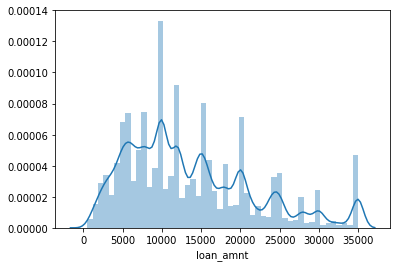

In [246]:
sns.distplot(df["loan_amnt"])

### 2. term
* term: The number of payments on the loan. Values are in months and can be either 36 or 60.

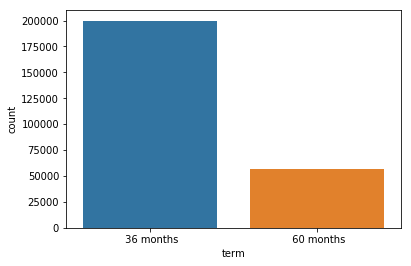

In [247]:
sns.countplot(df["term"])

In [248]:
def bar_group(column):
    #groupby loan status with the column
    column_dist = df.groupby(["loan_status",column]).agg({column:"count"})
    #fix the df in order to calculate the percentage easier...
    column_dist = column_dist.rename(columns={column: column+"_dist"}).reset_index()
    #add a new column which is the percentage, and round it to two decimals
    column_dist[column+"_dist"] = (column_dist[column+"_dist"]/column_dist[column+"_dist"].sum() * 100).apply(lambda row: round(row,2))
    return column_dist

In [249]:
df_dist = bar_group("term")
df_dist

,loan_status,term,term_dist
0,0,36 months,11.85
1,0,60 months,6.53
2,1,36 months,65.92
3,1,60 months,15.70


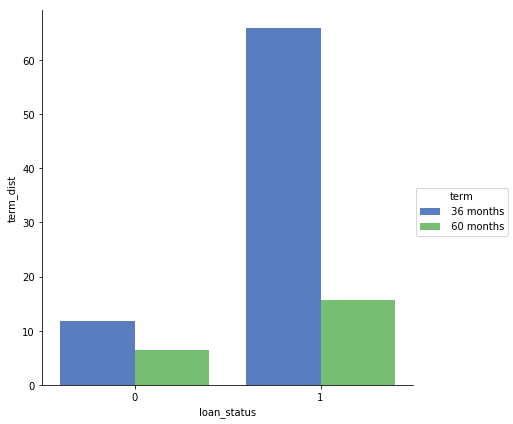

In [250]:
ax = sns.factorplot(x="loan_status", y="term_dist", hue="term", data=df_dist,
                   size=6, kind="bar", palette="muted")

### 3. int_rate

* int_rate: Interest Rate on the loan

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


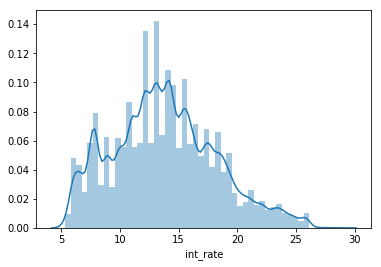

In [34]:
sns.distplot(df["int_rate"]);

### 4. grade, sub_grade
* grade: LC assigned loan grade
* sub_grade: LC assigned loan subgrade

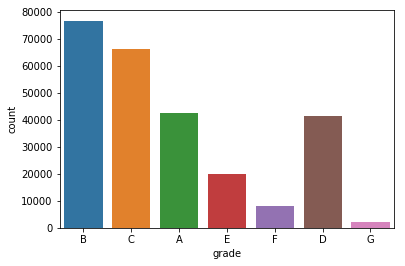

In [35]:
sns.countplot(df["grade"])

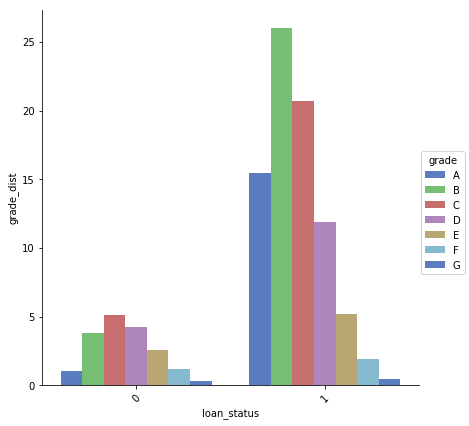

In [36]:
df_dist = bar_group("grade")
sns.factorplot(x="loan_status", y="grade_dist", hue="grade", data=df_dist,
                   size=6, kind="bar", palette="muted")
plt.xticks(rotation=45)
plt.show()

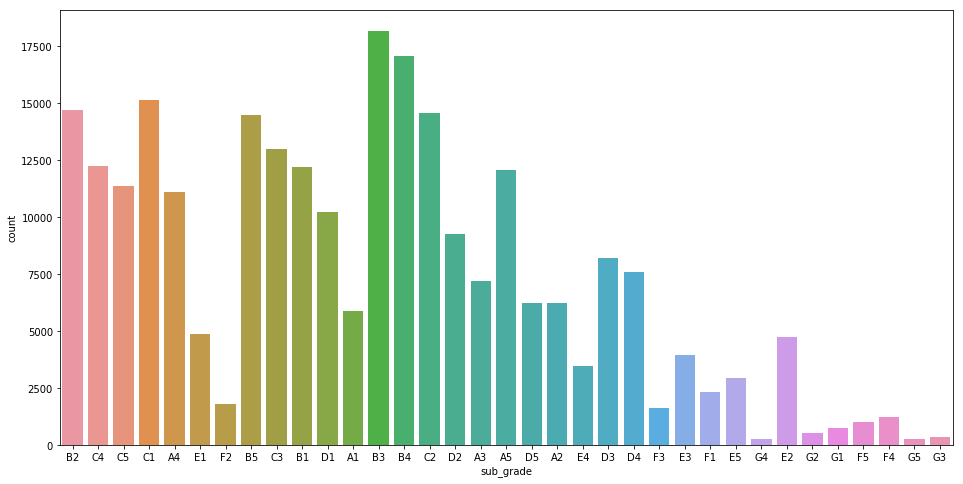

In [37]:
plt.figure(figsize=(16,8))
sns.countplot(df["sub_grade"])


(array([0, 1]), <a list of 2 Text xticklabel objects>)

<Figure size 1152x576 with 0 Axes>

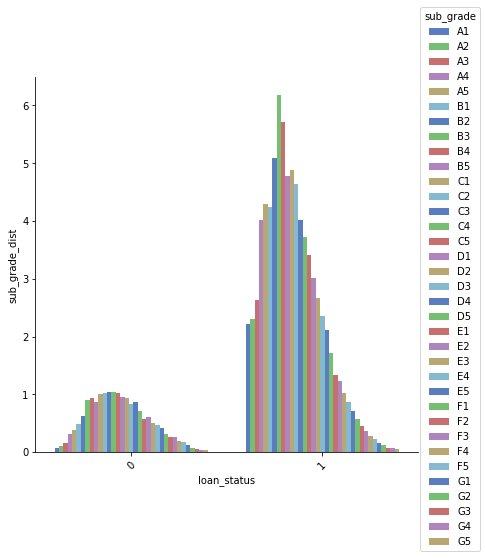

In [38]:
df_dist = bar_group("sub_grade")
plt.figure(figsize=(16,8))
sns.factorplot(x="loan_status", y="sub_grade_dist", hue="sub_grade", data=df_dist,
                   size=6, kind="bar", palette="muted")
plt.xticks(rotation=45)

In [39]:
df.sub_grade = df.sub_grade.apply(lambda row: row[1])

### 5. emp_title
* The job title supplied by the Borrower when applying for the loan.

In [40]:
df.emp_title.isnull().sum()/df.shape[0] * 100

5.514538470220558

5% of `emp_title` feature is filled with null value.


In [41]:
df.emp_title.value_counts().head()

Manager             1959
Teacher             1927
Supervisor           863
Registered Nurse     848
RN                   844
Name: emp_title, dtype: int64

In [42]:
len(df.emp_title.unique())

134759

In [43]:
df.emp_title.value_counts()[0]/df.shape[0] * 100

0.7624377770599248

In [44]:
df.emp_title.fillna("Missing",inplace=True)

Later, I will apply Natural Language processiong to this column.

### 6. title
* title: The loan title provided by the borrower

In [253]:
df.title.value_counts()

debt consolid                            88844
credit card refinanc                     23286
home improv                               9079
consolid                                  6952
other                                     6175
debt consolid loan                        3853
person loan                               2670
credit card consolid                      2618
major purchas                             2438
consolid loan                             1952
busi                                      1851
credit card                               1811
credit card payoff                        1768
credit card refin                         1676
person                                    1607
medic expens                              1508
loan                                      1174
vacat                                     1024
car financ                                1008
debt                                       991
payoff                                     969
credit card l

In [254]:
df.title.isnull().sum()

0

There are 15 null values. Since it is a categorical data, I will fill null values with 'Unkown' value.

In [255]:
df.title.fillna('Unknown', inplace=True)

Later, I will apply Natural Language processiong to this column.

### 7. emp_length
* emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

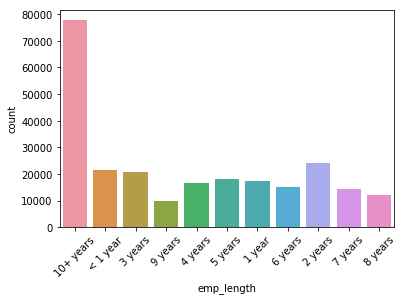

In [47]:
sns.countplot(df["emp_length"])
plt.xticks(rotation=45);


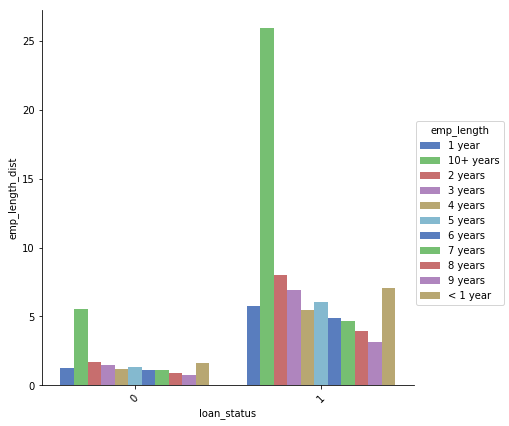

In [48]:
df_dist = bar_group("emp_length")
sns.factorplot(x="loan_status", y="emp_length_dist", hue="emp_length", data=df_dist,
                   size=6, kind="bar", palette="muted")
plt.xticks(rotation=45)
plt.show()

In [49]:
df.emp_length.fillna("Missing",inplace=True)

### 8. home_ownership
* home_ownership: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

In [50]:
df.home_ownership.value_counts()

MORTGAGE    126598
RENT        107831
OWN          22282
OTHER          179
NONE            48
ANY              1
Name: home_ownership, dtype: int64

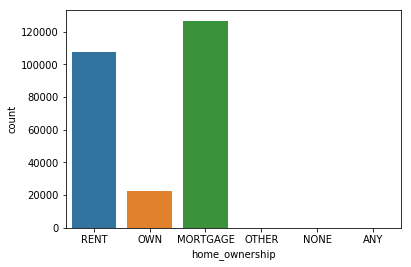

In [51]:
sns.countplot(x=df['home_ownership']);

(array([0, 1]), <a list of 2 Text xticklabel objects>)

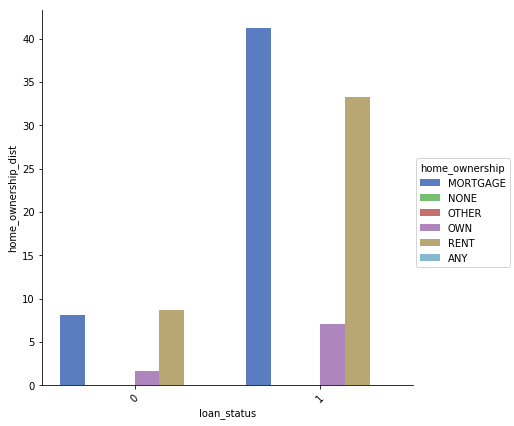

In [52]:
df_dist = bar_group("home_ownership")
sns.factorplot(x="loan_status", y="home_ownership_dist", hue="home_ownership", data=df_dist,
                   size=6, kind="bar", palette="muted");


plt.xticks(rotation=45)


### 9. annual_inc
* annual_inc: The self-reported annual income provided by the borrower during registration.

In [53]:
df.annual_inc.isnull().sum()

4

There are only 4 missing values. Let's replace them with median value of feature which is more robust to outlier than mean.

In [54]:
print("Median of annual_inc: ", df.annual_inc.median())
print("Mean of annual_inc:   ", df.annual_inc.mean())

Median of annual_inc:  62000.0
Mean of annual_inc:    72498.85345196234


In [55]:
df.annual_inc.fillna(df.annual_inc.median(), inplace= True)

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


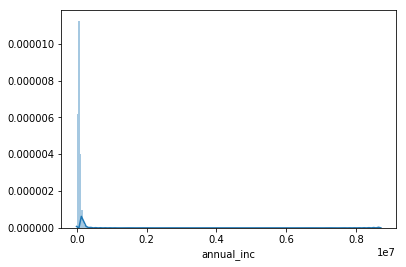

In [56]:
sns.distplot(df["annual_inc"], bins=200);

We can see that `annual_inc` is heavily skewed with outlier. Let's focus on range of [0,500000)

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


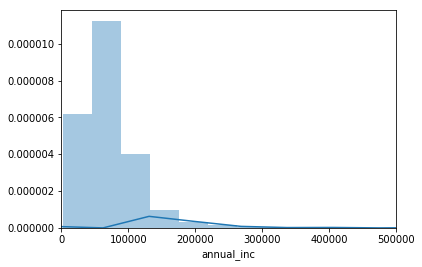

In [57]:
sns.distplot(df["annual_inc"], bins=200)
plt.xlim(0,500000);

### 10. verification_status
* verification_status

In [58]:
df.verification_status.value_counts()

Verified           94002
Not Verified       88174
Source Verified    74763
Name: verification_status, dtype: int64

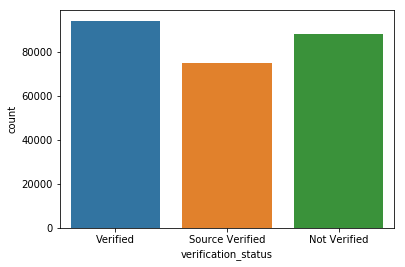

In [59]:
sns.countplot(df["verification_status"])

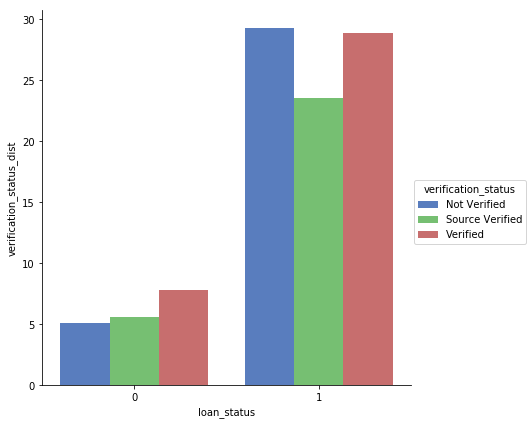

In [60]:
df_dist = bar_group("verification_status")
sns.factorplot(x='loan_status', y='verification_status_dist', hue = 'verification_status', data = df_dist,
              size=6, kind="bar", palette="muted")

### 11. pymnt_plan
* pymnt_plan: Indicates if a payment plan has been put in place for the loan

In [61]:
df.pymnt_plan.value_counts()

n    256937
y         2
Name: pymnt_plan, dtype: int64

In [62]:
df.drop('pymnt_plan', axis=1, inplace=True)

### 12. url
* url: URL for the LC page with listing data.

In [271]:
df['url'].value_counts()

https://www.lendingclub.com/browse/loanDetail.action?loan_id=40187434    1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=52036163    1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=20099419    1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=5960276     1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=65755814    1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=26308400    1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=14598519    1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=47767271    1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=58051009    1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=27531299    1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=24715269    1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=806870      1
https://www.lendingclub.com/browse/loanDetail.action?loan_id=10736223    1
https://www.lendingclub.c

Since each application has its own URL, I believe this column has no use for us, so I'll drop this column.

In [63]:
df.drop('url', axis=1, inplace=True)

### 13. purpose
* purpose: A category provided by the borrower for the loan request. 

In [64]:
df.purpose.value_counts()

debt_consolidation    150253
credit_card            50649
home_improvement       15190
other                  14766
major_purchase          6402
small_business          4926
car                     3720
medical                 2927
moving                  2085
wedding                 2011
house                   1703
vacation                1615
educational              422
renewable_energy         270
Name: purpose, dtype: int64

This categorical `purpose` feature is well-classified.

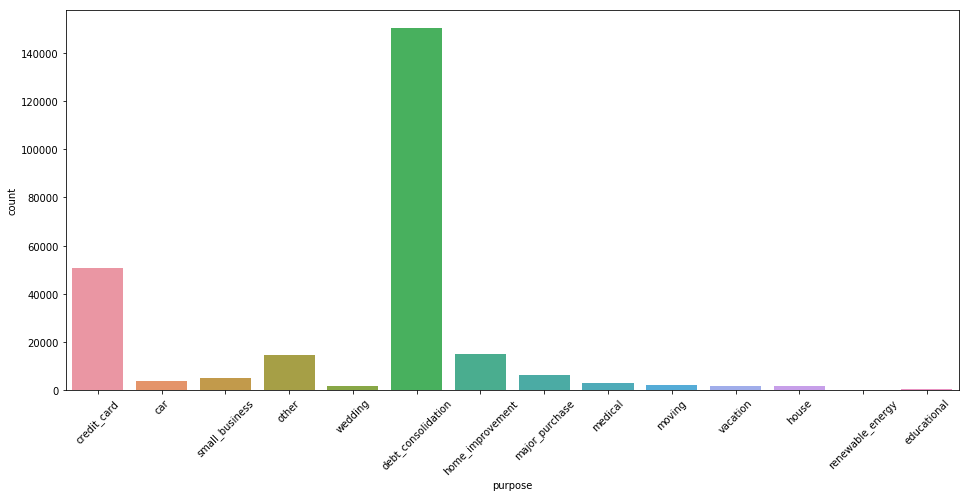

In [65]:
plt.figure(figsize=(16,7))
sns.countplot(df['purpose'])

plt.xticks(rotation=45);

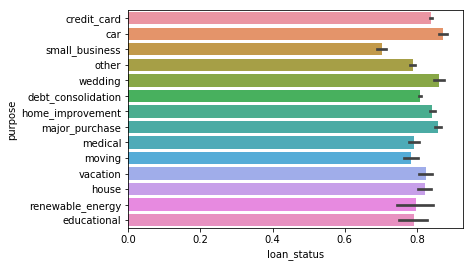

In [66]:
df_dist = bar_group('purpose')
sns.barplot(x='loan_status', y = 'purpose', data=df)

### 14. zip_code, addr_state
* zip_code: The first 3 numbers of the zip code provided by the borrower in the loan application.
* addr_state: The state provided by the borrower in the loan application

In [70]:
df.zip_code.value_counts().head()

945xx    3316
112xx    2873
750xx    2804
100xx    2583
900xx    2512
Name: zip_code, dtype: int64

It looks like `zip_code` does not represent data effectively. I will drop this feature.

In [71]:
df.drop('zip_code', axis=1, inplace=True)

We dont want to be bias toward people demographics so we will also drop the `address_state`

In [72]:
df.drop('addr_state', axis=1, inplace=True)

### 15. dti
* dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


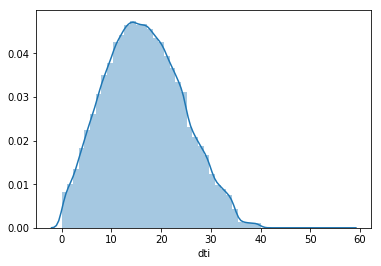

In [73]:
sns.distplot(df['dti']);

### 16. delinq_2yrs
* delinq_2yrs: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

In [74]:
df.delinq_2yrs.isnull().sum()

29

Considering the entire number of data, only small number of values are null. Let's fill them with median of column

In [75]:
df.delinq_2yrs.fillna(df.delinq_2yrs.median(), inplace=True)

In [76]:
df.delinq_2yrs.value_counts()

0.0     215544
1.0      28612
2.0       7902
3.0       2611
4.0       1058
5.0        552
6.0        270
7.0        145
8.0         88
9.0         52
10.0        31
12.0        24
11.0        22
14.0         8
13.0         5
15.0         4
18.0         4
16.0         2
17.0         2
22.0         1
19.0         1
29.0         1
Name: delinq_2yrs, dtype: int64

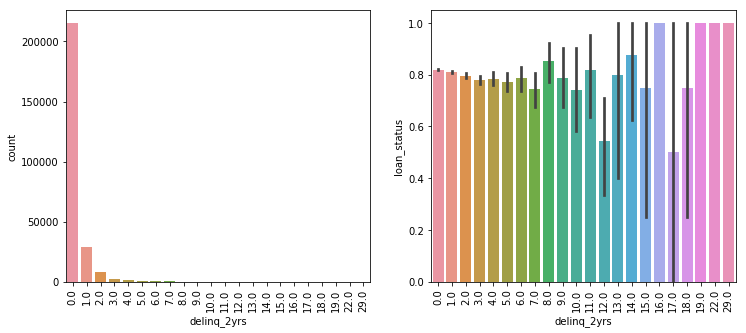

In [77]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(df["delinq_2yrs"])
plt.xticks(rotation="vertical")
plt.subplot(1,2,2)
sns.barplot(x="delinq_2yrs", y="loan_status", data=df)
plt.xticks(rotation="vertical")
plt.show()

### 17. earliest_cr_line
* earliest_cr_line: The month the borrower's earliest reported credit line was opened

In [78]:
df.earliest_cr_line.isnull().sum()

29

In [79]:
df.earliest_cr_line.value_counts().head()

Oct-2000    2143
Oct-1999    2002
Oct-2001    1981
Nov-2000    1957
Aug-2000    1942
Name: earliest_cr_line, dtype: int64

This column has weak representation power. Let's drop this.

In [80]:
df.drop('earliest_cr_line', axis=1, inplace=True)

### 18. inq_last_6mths
* inq_last_6mths: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

In [81]:
df.inq_last_6mths.isnull().sum()

29

In [82]:
df.inq_last_6mths.value_counts()

0.0     124680
1.0      73362
2.0      35074
3.0      16264
4.0       4443
5.0       1833
6.0        798
7.0        193
8.0        118
9.0         50
10.0        24
12.0        15
11.0        15
15.0         9
13.0         6
14.0         6
18.0         4
16.0         3
19.0         2
17.0         2
24.0         2
20.0         1
27.0         1
28.0         1
33.0         1
25.0         1
32.0         1
31.0         1
Name: inq_last_6mths, dtype: int64

In [83]:
df.inq_last_6mths.fillna(df.inq_last_6mths.median(), inplace=True)

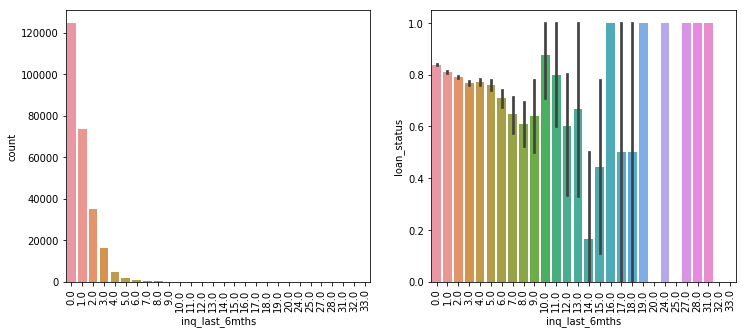

In [84]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(df["inq_last_6mths"])
plt.xticks(rotation="vertical")
plt.subplot(1,2,2)
sns.barplot(x="inq_last_6mths", y="loan_status", data=df)
plt.xticks(rotation="vertical")
plt.show()

### 19. pub_rec
* pub_rec: Number of derogatory public records

In [85]:
df.pub_rec.isnull().sum()

29

In [86]:
df.pub_rec.value_counts()

0.0     225511
1.0      27752
2.0       2583
3.0        687
4.0        204
5.0         94
6.0         39
7.0         19
8.0          8
9.0          5
10.0         5
11.0         1
12.0         1
15.0         1
Name: pub_rec, dtype: int64

In [87]:
df.pub_rec.fillna(df.pub_rec.median(), inplace=True)

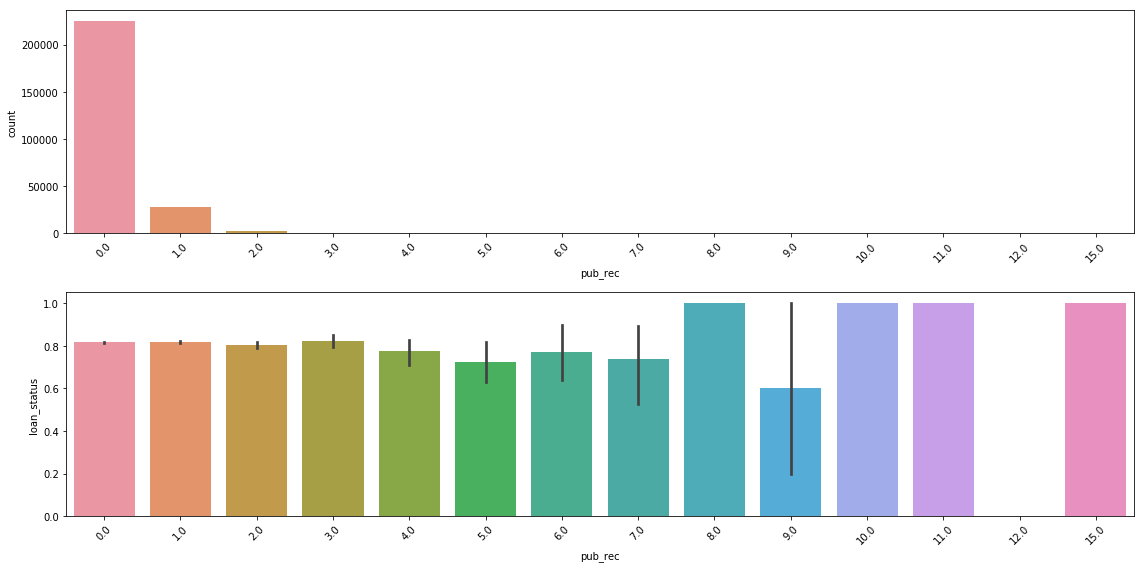

In [88]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
sns.countplot(df["pub_rec"])
plt.xticks(rotation=45)
plt.subplot(2,1,2)
sns.barplot(x="pub_rec", y="loan_status", data=df)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 20. revol_bal
* revol_bal: Total credit revolving balance

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


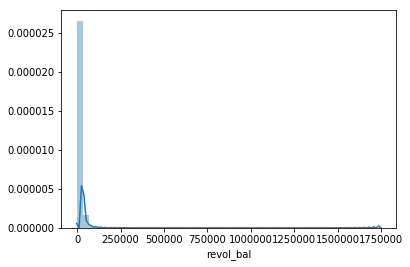

In [89]:
sns.distplot(df.revol_bal)

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 100000)

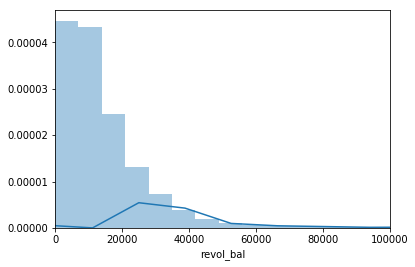

In [90]:
sns.distplot(df.revol_bal, bins=250)
plt.xlim(0,100000)

sns.distplot(loan.revol_bal, bins=250)
plt.xlim(0,100000)

### 21. revol_util
* revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [91]:
df.revol_util.isnull().sum()

240

In [92]:
df.revol_util.value_counts().head()

0.0     1897
63.0     456
62.0     448
57.0     446
58.0     445
Name: revol_util, dtype: int64

In [93]:
df.revol_util.fillna(df.revol_util.median(), inplace=True)

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


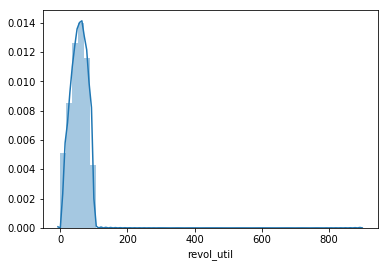

In [94]:
sns.distplot(df.revol_util)

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 150)

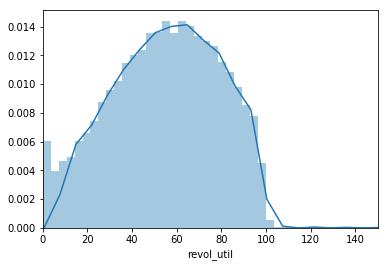

In [95]:
sns.distplot(df.revol_util, bins=250)
plt.xlim(0,150)

### 22. total_acc
* total_acc: The total number of credit lines currently in the borrower's credit file

In [96]:
df.total_acc.isnull().sum()

29

In [97]:
df.total_acc.value_counts().head()

20.0    9340
21.0    9326
22.0    9231
19.0    9098
23.0    9037
Name: total_acc, dtype: int64

In [98]:
df.total_acc.fillna(df.total_acc.median(), inplace=True)

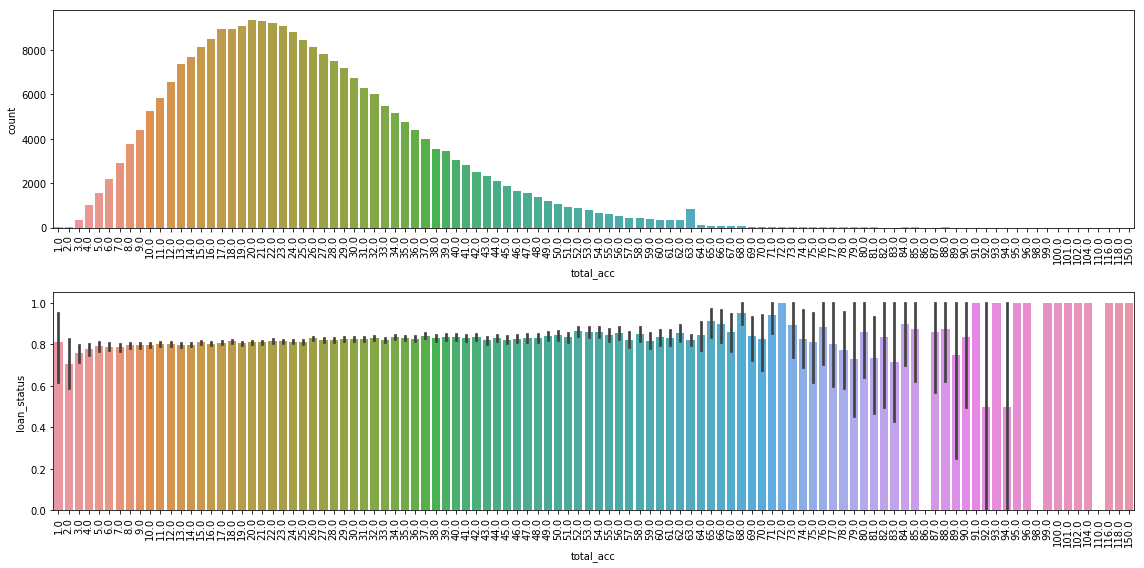

In [99]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
sns.countplot(df["total_acc"])
plt.xticks(rotation="vertical")
plt.subplot(2,1,2)
sns.barplot(x="total_acc", y="loan_status", data=df)
plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

### 23. initial_list_status
* initial_list_status: The initial listing status of the loan. Possible values are – W, F

In [100]:
df.initial_list_status.value_counts()

f    185496
w     71443
Name: initial_list_status, dtype: int64

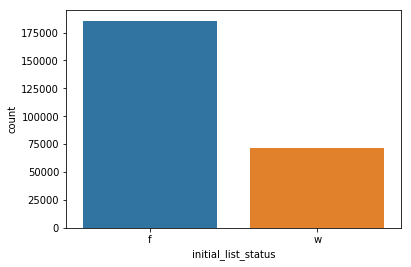

In [101]:
sns.countplot(df["initial_list_status"])


<Figure size 864x576 with 0 Axes>

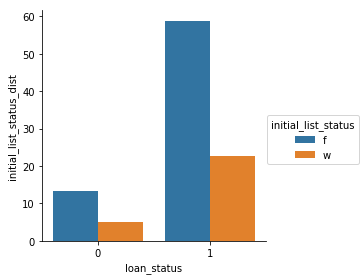

In [102]:
df_dist = bar_group('initial_list_status')
plt.figure(figsize=(12,8))
sns.factorplot(x='loan_status', y='initial_list_status_dist', hue='initial_list_status', kind='bar', data= df_dist)

### 24. last_credit_pull_d
* last_credit_pull_d: The most recent month LC pulled credit for this loan

In [103]:
df.last_credit_pull_d.value_counts().head()

Jan-2016    103973
Dec-2015     18534
Nov-2015     10969
Oct-2015      9993
Sep-2015      9758
Name: last_credit_pull_d, dtype: int64

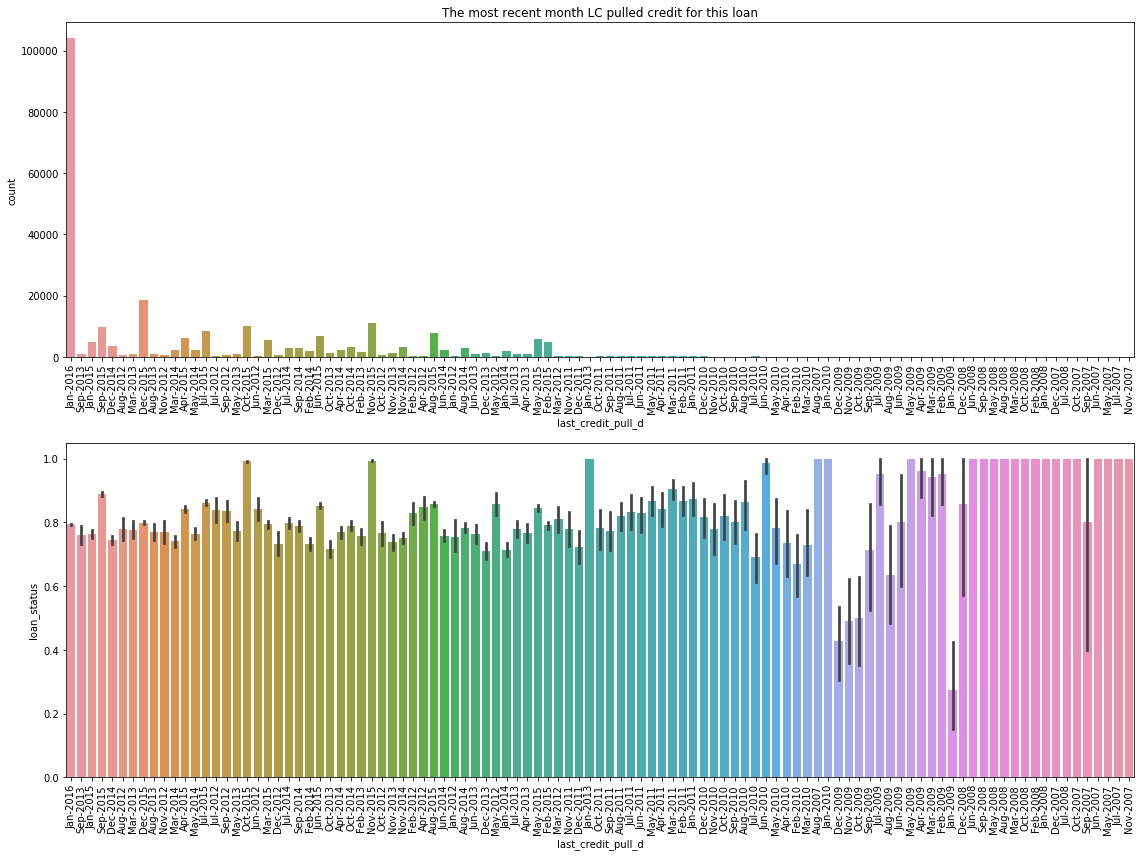

In [104]:
plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
plt.title('The most recent month LC pulled credit for this loan')
sns.countplot(df["last_credit_pull_d"])
plt.xticks(rotation='vertical')
plt.subplot(2,1,2)
sns.barplot(x="last_credit_pull_d", y="loan_status", data=df)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

Based on personal judgement, the last credit check date doesnt impact our target variable.
what matters is the credit check result, not when it was done.

In [105]:
df.drop('last_credit_pull_d', axis=1, inplace=True)

In [106]:
df.shape

(256939, 27)

### 25. collections_12_mths_ex_med
* collections_12_mths_ex_med: Number of collections in 12 months excluding medical collections

In [107]:
df.collections_12_mths_ex_med.value_counts().head()

0.0    255201
1.0      1484
2.0        97
3.0         8
4.0         2
Name: collections_12_mths_ex_med, dtype: int64

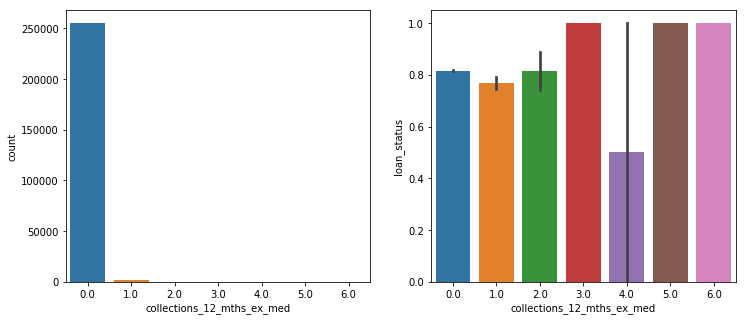

In [108]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(df["collections_12_mths_ex_med"])
plt.subplot(1,2,2)
sns.barplot(x="collections_12_mths_ex_med", y="loan_status", data=df)
plt.show()

This feature's value is mostly gathered in 0.0. It seems it cannot effectively provide information in predicting model. Let's drop this.

In [109]:
df.drop('collections_12_mths_ex_med', axis=1, inplace=True)

### 26. policy_code
* policy_code: 
    * publicly available policy_code=1
    * new products not publicly available policy_code=2

In [110]:
df.policy_code.value_counts()

1.0    256939
Name: policy_code, dtype: int64

In [111]:
df.shape[0]

256939

All of data are having this value of 1.0! Let's drop this feature for computation efficiency.

In [112]:
df.drop('policy_code', axis=1, inplace=True)

### 27. application_type
* application_type: Indicates whether the loan is an individual application or a joint application with two co-borrowers

In [113]:
df.application_type.value_counts()

INDIVIDUAL    256938
JOINT              1
Name: application_type, dtype: int64

In [114]:
df.application_type.value_counts()/df.shape[0] * 100

INDIVIDUAL    99.999611
JOINT          0.000389
Name: application_type, dtype: float64

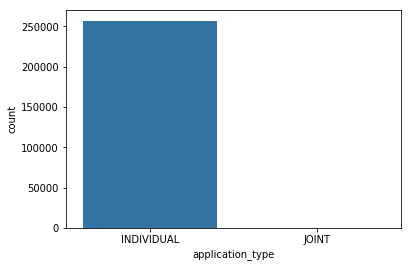

In [115]:
sns.countplot(df['application_type'])

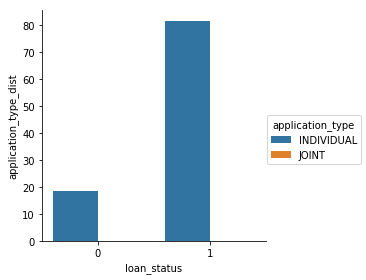

In [116]:
df_dist= bar_group('application_type')
sns.factorplot(x='loan_status', y='application_type_dist', kind='bar', hue='application_type', data=df_dist)

Again, 99.998% of data are having this value as 'INDIVIDUAL'. Let's drop this column.

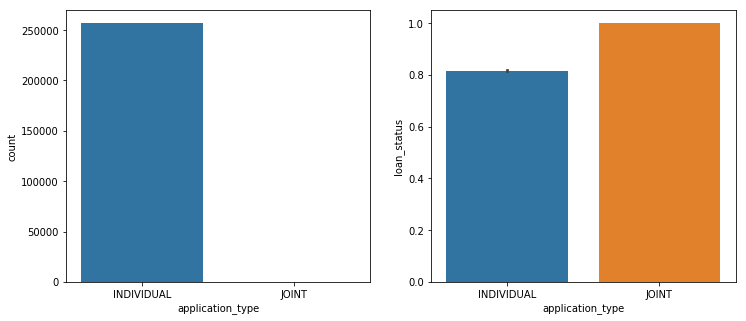

In [117]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(df["application_type"])
plt.subplot(1,2,2)
sns.barplot(x="application_type", y="loan_status", data=df)
plt.show()

In [118]:
df.drop('application_type', axis=1, inplace=True)

### 28. acc_now_delinq
* acc_now_delinq: The number of accounts on which the borrower is now delinquent.

In [119]:
df.acc_now_delinq.value_counts()

0.0    256165
1.0       703
2.0        36
3.0         3
5.0         2
4.0         1
Name: acc_now_delinq, dtype: int64

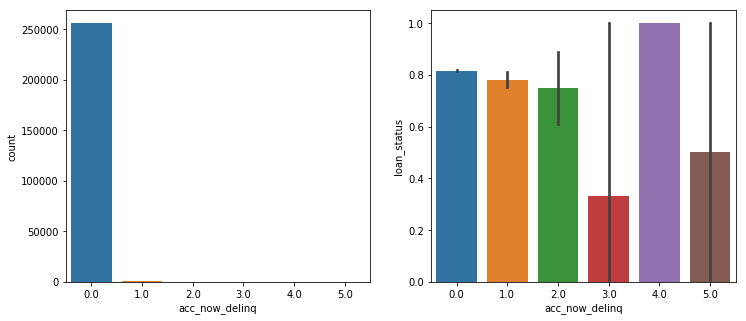

In [120]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(df["acc_now_delinq"])
plt.subplot(1,2,2)
sns.barplot(x="acc_now_delinq", y="loan_status", data=df)
plt.show()

They are all correlated with the positive class, so i decided to drop them!

In [121]:
df.drop('acc_now_delinq', axis=1, inplace=True)

### 29.  tot_coll_amt, tot_cur_bal, total_rev_hi_lim
* tot_coll_amt: Total collection amounts ever owed
* tot_cur_bal: Total current balance of all accounts
* total_rev_hi_lim: Total revolving high credit/credit limit

In [122]:
df.tot_coll_amt.isnull().sum()/df.shape[0]

0.25871899555925726

In [123]:
df.tot_coll_amt.value_counts().head()/df.shape[0]

0.0      0.656144
50.0     0.001362
100.0    0.001183
75.0     0.000930
150.0    0.000557
Name: tot_coll_amt, dtype: float64

24% of values are null and 67% are having 0.0 as its value. Let's drop this column.

In [267]:
df.drop('tot_coll_amt', axis=1, inplace=True)

#### tot_cur_bal

In [126]:
df.tot_cur_bal.isnull().sum()/df.shape[0]

0.25871899555925726

In [127]:
df.tot_cur_bal.value_counts().head(15)

0.0        50
19376.0     9
25341.0     9
28674.0     9
13530.0     9
4875.0      9
30491.0     9
22060.0     8
21944.0     8
15886.0     8
45492.0     8
30652.0     8
16709.0     8
27222.0     8
18311.0     8
Name: tot_cur_bal, dtype: int64

In [128]:
df.tot_cur_bal.median()

80760.5

In [129]:
df.tot_cur_bal.mean()

138160.4572937668

/Users/haniawattar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0, 1000000.0)

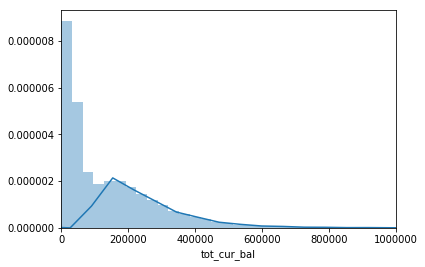

In [130]:
sns.distplot(df.tot_cur_bal[df.tot_cur_bal.isnull()==False], bins=250)
plt.xlim(0,0.1e7)

This column is very ambiguous to deal with. The 24% of the features are null values but it is hard to replace them with mean or median since this feature is widely distributed. I decided not to use this column in prediction.

In [131]:
df.drop('tot_cur_bal', axis=1, inplace=True)

In [132]:
df.shape

(256939, 22)

## NLP to title and emp_title

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk.stem

english_stemmer = nltk.stem.SnowballStemmer('english')

In [260]:
df.title = df.title.apply(lambda sent: " ".join([english_stemmer.stem(word) for word in str(sent).split()]))

In [261]:
df.emp_title = df.emp_title.apply(lambda sent: " ".join([english_stemmer.stem(word) for word in str(sent).split()]))

In [262]:
df.title.head()

0                             comput
1                               bike
2                    real estat busi
3                           personel
5    my wed loan i promi to pay back
Name: title, dtype: object

In [263]:
df.emp_title.head()

0                    miss
1                   ryder
2                    miss
3       air resourc board
5    veolia transportaton
Name: emp_title, dtype: object

In [264]:
title = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',min_df=2,stop_words="english",
                        ngram_range=(1, 2)).fit_transform(df.title.tolist())

emp_title = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',min_df=2,stop_words="english",
                         ngram_range=(1, 2)).fit_transform(df.emp_title.tolist())

In [265]:
title.shape

(256939, 10850)

In [142]:
emp_title.shape

(256939, 46114)

Now, lets stack those two features together...

In [143]:
from scipy.sparse import hstack #HORIZENTAL STACK 

In [144]:
texts_vecs = hstack([title,emp_title])

In [145]:
texts_vecs.shape

(256939, 56979)

--------------

## Encoding categorical variables

In [146]:
categorical_variables = ['term', 'grade','sub_grade', 'emp_length', 'home_ownership', 'verification_status',
               'purpose', 'initial_list_status']

features =  list(set(df.columns) - set(categorical_variables))

In [147]:
def one_hot_encoder(df):
    loan_one_hot_encoded = pd.get_dummies(df, columns=categorical_variables,drop_first=True)
    print("====================[Data Types]====================")
    print(loan_one_hot_encoded.dtypes)
    return loan_one_hot_encoded
loan_one_hot_encoded = one_hot_encoder(df)

====================[Data Types]====================
loan_amnt                              float64
int_rate                               float64
emp_title                               object
annual_inc                             float64
loan_status                              int64
title                                   object
dti                                    float64
delinq_2yrs                            float64
inq_last_6mths                         float64
pub_rec                                float64
revol_bal                              float64
revol_util                             float64
total_acc                              float64
tot_coll_amt                           float64
term_ 60 months                          uint8
grade_B                                  uint8
grade_C                                  uint8
grade_D                                  uint8
grade_E                                  uint8
grade_F                                  uint8
grade_G

In [241]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False) #Normalization

# Train-Test split
y = loan_one_hot_encoded.loan_status
X = loan_one_hot_encoded.drop(["loan_status","title","emp_title"], axis=1)

X_all = scaler.fit_transform(hstack([np.array(X),texts_vecs]))

x_train, x_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, stratify=y,random_state=123)

In [152]:
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (205551, 57033)
Shape of y_train:  (205551,)
Shape of x_test:  (51388, 57033)
Shape of y_test:  (51388,)


# LOGISTIC REGRESSION

In [153]:
from sklearn.linear_model import LogisticRegression

In [223]:
LR = LogisticRegression()

In [224]:
LR.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [225]:
y_pred = LR.predict(x_test)


In [226]:
LR.score(x_test, y_test)

0.7746750214057757

In [227]:
from sklearn.metrics import confusion_matrix

In [228]:
cf_mat = confusion_matrix(y_test, y_pred)
cf_mat_p = cf_mat/cf_mat.sum()


In [229]:
cf_mat

array([[ 1541,  7905],
       [ 3674, 38268]])

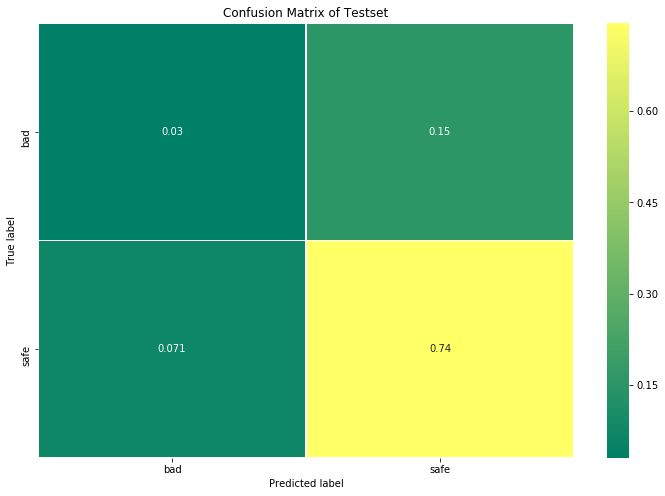

In [230]:
# Plot normalized confusion matrix
import matplotlib.cm as cm
plt.figure(figsize=(12,8))
sns.heatmap(cf_mat_p, annot=True, linewidths=.5, cmap=cm.summer,xticklabels=['bad','safe'], yticklabels=['bad','safe'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix of Testset")
plt.show()

# NEURAL NETWORK

In [238]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

def encode_neural_net_y(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    new_y = np_utils.to_categorical(encoded_y)
    return new_y


# Neural Network model
y_train = encode_neural_net_y(y_train)
y_test = encode_neural_net_y(y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

# create model
model = Sequential()

model.add(Dense(64, activation='relu', input_dim=x_train.shape[1],use_bias=False))

model.add(BatchNormalization()) #Normalize each neuron weights to be centered with mean 0 and variance 1 

model.add(Dropout(0.3)) #drop a neuron weights with a %30 probablity

model.add(Dense(32, activation='relu',use_bias=False))

model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='binary_crossentropy',optimizer=sgd ,metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
#model.fit(x_train, y_train,epochs=50,batch_size=128)

In [235]:
from keras.models import load_model

In [236]:
model = load_model('model_best.h5')  

In [239]:
score = model.evaluate(x_test, y_test, batch_size=128)
score

51388/51388 [==============================] - 23s 438us/step


[0.3511794744098735, 0.8776173425795291]

In [ ]:
model.summary()

In [ ]:
model.get_config()

In [240]:
bi_preds_class = model.predict_classes(x_test)

In [ ]:

y_test

In [242]:
cf_mat = confusion_matrix(y_test, bi_preds_class)
cf_mat_p = cf_mat/cf_mat.sum()

In [243]:
cf_mat

array([[ 3901,  5545],
       [  744, 41198]])

In [245]:
3901/(3901+5545)

0.4129790387465594

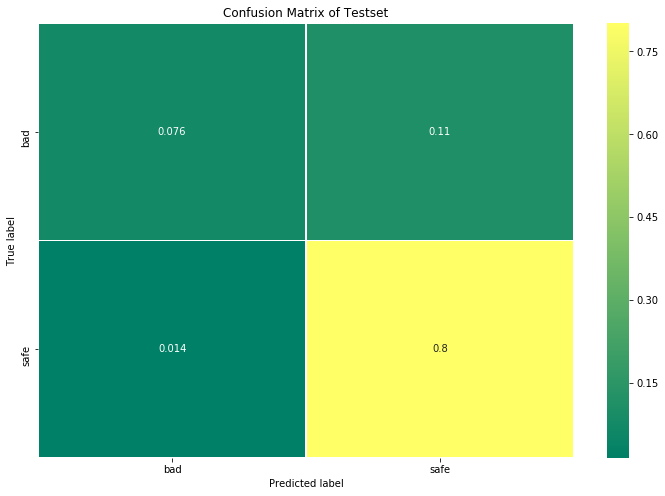

In [244]:
# Plot normalized confusion matrix
import matplotlib.cm as cm
plt.figure(figsize=(12,8))
sns.heatmap(cf_mat_p, annot=True, linewidths=.5, cmap=cm.summer,xticklabels=['bad','safe'], yticklabels=['bad','safe'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix of Testset")
plt.show()